# Percent Within X

The Percent Within X score evaluates how often a continuous single-valued forecast falls within a specified absolute error threshold of the observation. This is a simple and easy to explain metric, particularly useful for applications where a forecast is considered "close enough" if it lies within a certain band around the observation.

Unlike traditional error metrics (e.g. MAE or RMSE), the PERCENT_WITHIN_X score does not penalise outliers more harshly- it simply counts whether each forecast is inside or outside the acceptable range. 

Two versions are supported:
- Inclusive: Forecast is within or equal to the threshold (`|fcst - obs| ≤ τ`)
- Exclusive: Forecast must be strictly within the threshold (`|fcst - obs| < τ`)

This score is expressed as a percentage (0-100), representing the fraction of valid forecast-observation pairs that satisfy the condition.

## Important Caveat:

While the score is intuitive and operationally appealing, it is not a proper scoring rule. This means that it can encourage hedging. Forecasters may be incentivised to report values that maximise their score rather than reflect their true belief.

For example, when verifying wind speed forecasts with a fixed threshold (e.g. within 5 knots), a forecast of 5 knots will be scored as "correct" for any observed value between 0 and 10 knots. In contrast, a forecast of 0 will only be correct for observations between 0 and 5 knots. This creates an incentive to forecast values that maximise the width of the "acceptable" observation band - particularly in skewed or bounded distributions like wind speed or precipitation. In such cases, the best-scoring forecast may systematically over- or under-predict the truth, depending on how the threshold interacts with physical limits.

This issue arises because:
- The score only considers whether the forecast falls within a fixed band, not how close it is to the observation.
- All errors outside the threshold are treated equally, whether they are just over or wildly off.
- The threshold creates an artificial cutoff that can distort optimisation.

As a result, PERCENT_WITHIN_X is best understood as a user-facing diagnostic, valuable for answering operational questions like "how often do we get within 2 degrees?" However, it should not be used for model training or for rigorous forecast intercomparison.

For applications requiring properness, consider using metrics such as MAE, RMSE, or CRPS. 

## Mathematical Formulation

Inclusive form:

$$
\text{PERCENT_WITHIN_X} = 100 \cdot \frac{\sum_{i=1}^{N} \mathbf{1}(|x_i - y_i| \leq \tau)}{\sum_{i=1}^{N} \mathbf{1}_{\text{valid}}}
$$

Exclusive form:

$$
\text{PERCENT_WITHIN_X} = 100 \cdot \frac{\sum_{i=1}^{N} \mathbf{1}(|x_i - y_i| < \tau)}{\sum_{i=1}^{N} \mathbf{1}_{\text{valid}}}
$$

Where:
- $x_i$: forecast value  
- $y_i$: observed value  
- $\tau$: error threshold  
- $\mathbf{1}(\cdot)$: indicator function  
- $\mathbf{1}_{\text{valid}}$: 1 if both forecast and observation are not NaN  

## Implementation Notes in `scores`

- The `threshold` must be specified.
- Set `is_inclusive=True` (default) for `≤ τ` logic; set to `False` for strict `< τ`.
- Supports angular data with `is_angular=True`.
- Supports `reduce_dims` and `preserve_dims` to aggregate across or retain specific dimensions.
- Floating point precision can be controlled via `rounded_digits`.
- The score is positively oriented: higher values indicate better agreement.

## Calculating the PERCENT_WITHIN_X score in `scores`

In [1]:
from scores.continuous import percent_within_x, mae, pbias

# You can view the documentation for the function by running the following
# help(percent_within_x)

import numpy as np
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt

## Synthetic Forecast and Observation Data

To demonstrate the behavior of the Percent Within X (PERCENT_WITHIN_X) score, we construct synthetic forecast and observation data with realistic characteristics.

The dataset simulates a gridded variable over:
- 100 daily timesteps (`time`)
- 7 lead days (`lead`)
- 3 spatial locations (`location`)

### Observations

Observations are generated from a normal distribution with:
- Mean = 2.5  
- Standard deviation = 5  

These values are intended to reflect a continuous geophysical variable (e.g., temperature anomaly) with no inherent lower or upper bound. 

Later, we will experiment with variables bounded at zero which follow a skewed distribution, similar to precipitation or wind speed. 

### Forecasts

Forecasts are designed to:
- Have the same mean and standard deviation as the observations
- Be positively correlated with the observations at a level that decreases with increasing leadtime


In [2]:
# Dimensions
n_days = 100
n_leads = 7
n_locs = 3

# Coordinate labels
time = pd.date_range(start="2025-01-01", periods=n_days, freq="D")
lead = np.arange(1, n_leads + 1) 
location = [f"loc_{i}" for i in range(n_locs)]

rng = np.random.default_rng(seed=42)  # for reproducibility

# Step 1: Create realistic observations
obs_vals = rng.normal(loc=2.5, scale=5, size=(n_days, n_locs))
obs = xr.DataArray(obs_vals, coords=[time, location], dims=["time", "location"])

# Step 2: Broadcast obs across lead to build correlated forecasts
obs_mean = obs.mean().item()
obs_std = obs.std().item()
obs_norm = (obs - obs_mean) / obs_std

# Add synthetic lead-dependent correlation
rho_array = np.linspace(0.95, 0.05, n_leads).reshape((1, n_leads, 1)) 
obs_expanded = obs_norm.values[:, None, :] 

noise = rng.normal(size=obs_expanded.shape)
fcst_norm = rho_array * obs_expanded + np.sqrt(1 - rho_array**2) * noise
fcst_vals = fcst_norm * obs_std + obs_mean

fcst = xr.DataArray(fcst_vals, coords=[time, lead, location], dims=["time", "lead", "location"])


Now we calculate the percentage of forecasts that fall within 2 units (e.g., degrees Celsius) of the corresponding observations. By setting `is_inclusive=True`, we count forecasts as correct if their absolute error is *less than or equal to* 2 units.

The results are aggregated over time and location, so the output shows the score as a function of lead time. This is equivalent to specifying `preserve_dims=["lead"]` in the function call.


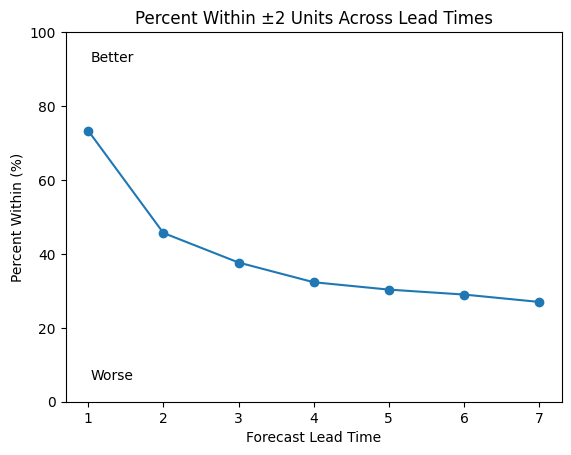

In [7]:
percent_within = percent_within_x(fcst=fcst, obs=obs, threshold=2.0, is_inclusive=True, reduce_dims=["time","location"])
fig, ax = plt.subplots()
percent_within.plot(ax=ax, marker='o')
ax.set_title("Percent Within ±2 Units Across Lead Times")
ax.set_ylabel("Percent Within (%)")
ax.set_xlabel("Forecast Lead Time")
ax.set_ylim(0, 100)
ax.annotate("Better", xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10)

ax.annotate("Worse", xy=(0.05, 0.05), xycoords='axes fraction',
            ha='left', va='bottom', fontsize=10)
plt.show()

Next, to demonstrate the caveat above about this score not being proper, we will evaluate forecasts that are bounded, such that they do not go below zero. Again, forecast performance is lower at longer leads. We will evaluate the percent of forecasts within 5 knots of the observation. We will also create a hedged forecast which is attempting to cheat the score by never forecasting less than 5 knots. 

In [4]:
# Step 1: Create realistic observations
obs_vals = rng.gamma(shape=2.0, scale=4.0, size=(n_days, n_locs))
zero_mask = rng.uniform(size=obs_vals.shape) < 0.3
obs_vals[zero_mask] = 0.0

obs = xr.DataArray(obs_vals, coords=[time, location], dims=["time", "location"])

# Step 2: Broadcast obs across lead to build correlated forecasts
obs_mean = obs.mean().item()
obs_std = obs.std().item()
obs_norm = (obs - obs_mean) / obs_std

# Add synthetic lead-dependent correlation
rho_array = np.linspace(0.95, 0.05, n_leads).reshape((1, n_leads, 1))
obs_expanded = obs_norm.values[:, None, :]

noise = rng.normal(size=obs_expanded.shape)
fcst_norm = rho_array * obs_expanded + np.sqrt(1 - rho_array**2) * noise
fcst_vals = fcst_norm * obs_std + obs_mean
fcst_vals = np.clip(fcst_vals, 0, None)

fcst = xr.DataArray(fcst_vals, coords=[time, lead, location], dims=["time", "lead", "location"])

# Prevent hedged forecasts from ever going below 5 knots
fcst_hedged_vals = np.clip(fcst_vals, 5, None)

fcst_hedged = xr.DataArray(fcst_hedged_vals, coords=[time, lead, location], dims=["time", "lead", "location"])


Now we will visualise, for the case of lead-day 7 forecasts, the effects of hedging on performance. In the below scatterplots the entries falling between the dashed lines are within 5 knots of the observed. By changing any forecast below 5 knots to equal a forecast of exactly 5 knots, we bring more outcomes into the acceptable range. 

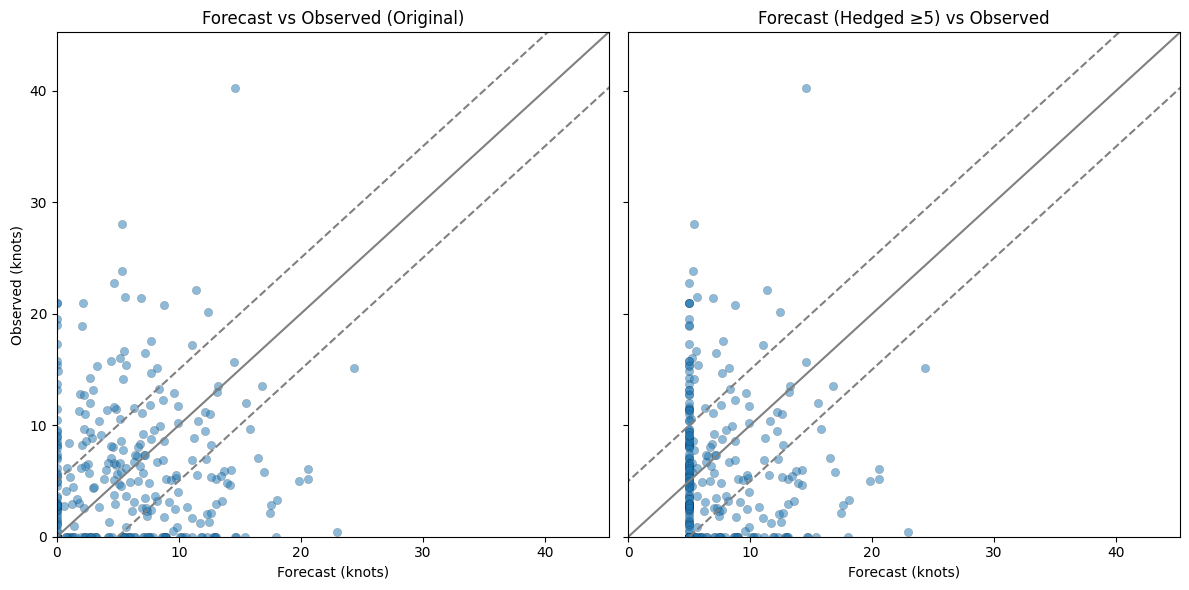

In [8]:
# Select forecasts at lead of interest
fcst_lead1 = fcst.sel(lead=7)
fcst_hedged_lead1 = fcst_hedged.sel(lead=7)

# Flatten across time and location
obs_flat = obs.values.flatten()
fcst_flat = fcst_lead1.values.flatten()
fcst_hedged_flat = fcst_hedged_lead1.values.flatten()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

# Determine range of plots
obs_max = obs_flat.max()
fcst_max = fcst_flat.max()
fcst_hedge_max = fcst_hedged_flat.max()
max_values = [obs_max, fcst_max, fcst_hedge_max]
max_val = max(max_values)

# Plot unhedged forecasts versus observations
axes[0].scatter(fcst_flat, obs_flat, alpha=0.5, edgecolor='k', linewidth=0.2)
axes[0].plot([0, max_val+5], [0, max_val+5], '-', color='gray')
axes[0].plot([5, max_val+10], [0, max_val+5], '--', color='gray')
axes[0].plot([-5, max_val], [0, max_val+5], '--', color='gray')
axes[0].set_xlim(0, max_val+5)
axes[0].set_ylim(0, max_val+5)
axes[0].set_title("Forecast vs Observed (Original)")
axes[0].set_xlabel("Forecast (knots)")
axes[0].set_ylabel("Observed (knots)")

# Plot hedged forecasts versus observations
axes[1].scatter(fcst_hedged_flat, obs_flat, alpha=0.5, edgecolor='k', linewidth=0.2)
axes[1].plot([0, max_val+5], [0, max_val+5], '-', color='gray')
axes[1].plot([5, max_val+10], [0, max_val+5], '--', color='gray')
axes[1].plot([-5, max_val+5], [0, max_val+10], '--', color='gray')
axes[1].set_xlim(0, max_val+5)
axes[1].set_ylim(0, max_val+5)
axes[1].set_title("Forecast (Hedged ≥5) vs Observed")
axes[1].set_xlabel("Forecast (knots)")

plt.tight_layout()
plt.show()

Next we view the performance versus lead day and the improvements associated with hedging become clear. However, as the middle and right plots show, this comes at the expense of increased Mean Absolute Error and worse Bias. 

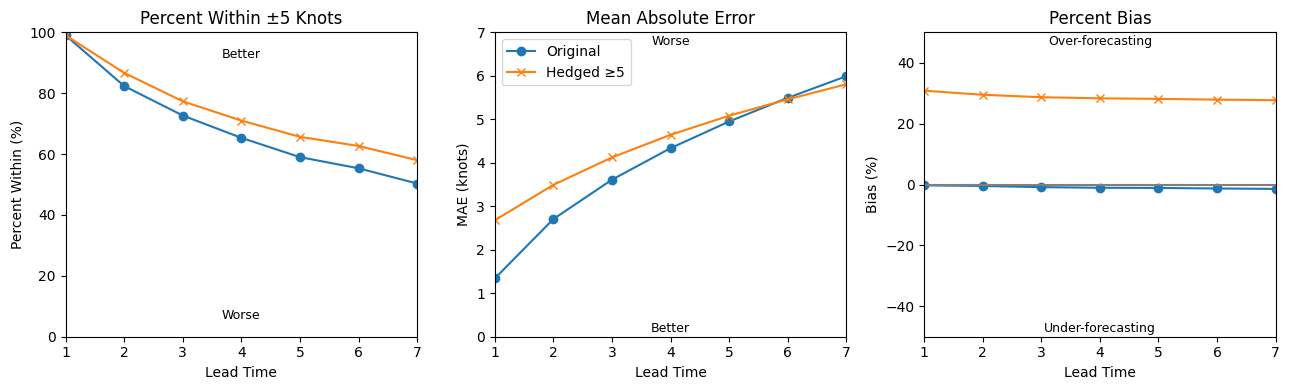

In [9]:
reduce_dims = ["time","location"]

# Calculate percent within
percent_within_x_orig = percent_within_x(fcst=fcst, obs=obs, threshold=5.0, is_inclusive=True, reduce_dims=reduce_dims)
percent_within_x_hedged = percent_within_x(fcst=fcst_hedged, obs=obs, threshold=5.0, is_inclusive=True, reduce_dims=reduce_dims)

# Calculate mean absolute error
mae_orig = mae(fcst=fcst, obs=obs, reduce_dims=reduce_dims)
mae_hedged = mae(fcst=fcst_hedged, obs=obs, reduce_dims=reduce_dims)

# Calculate percent bias
pbias_orig = pbias(fcst=fcst, obs=obs, reduce_dims=reduce_dims)
pbias_hedged = pbias(fcst=fcst_hedged, obs=obs, reduce_dims=reduce_dims)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharex=True)

# --- PERCENT_WITHIN_X subplot ---
percent_within_x_orig.plot(ax=axes[0], marker='o', label="Original")
percent_within_x_hedged.plot(ax=axes[0], marker='x', label="Hedged ≥5")
axes[0].set_title("Percent Within ±5 Knots")
axes[0].set_ylabel("Percent Within (%)")
axes[0].set_xlabel("Lead Time")
axes[0].annotate("Better", xy=(0.5, 0.95), xycoords='axes fraction',
                 ha='center', va='top', fontsize=9)
axes[0].annotate("Worse", xy=(0.5, 0.05), xycoords='axes fraction',
                 ha='center', va='bottom', fontsize=9)
axes[0].set_ylim(0, 100)
axes[0].set_xlim(1, 7)

# --- MAE subplot ---
mae_orig.plot(ax=axes[1], marker='o', label="Original")
mae_hedged.plot(ax=axes[1], marker='x', label="Hedged ≥5")
axes[1].set_title("Mean Absolute Error")
axes[1].set_ylabel("MAE (knots)")
axes[1].set_xlabel("Lead Time")
axes[1].annotate("Better", xy=(0.5, 0.05), xycoords='axes fraction',
                 ha='center', va='top', fontsize=9)
axes[1].annotate("Worse", xy=(0.5, 0.95), xycoords='axes fraction',
                 ha='center', va='bottom', fontsize=9)
axes[1].set_ylim(0, 7)
axes[1].set_xlim(1, 7)
axes[1].legend()

# --- PBIAS subplot ---
pbias_orig.plot(ax=axes[2], marker='o', label="Original")
pbias_hedged.plot(ax=axes[2], marker='x', label="Hedged ≥5")
axes[2].set_title("Percent Bias")
axes[2].set_ylabel("Bias (%)")
axes[2].set_xlabel("Lead Time")
axes[2].set_ylim(-50, 50)
axes[2].set_xlim(1, 7)
axes[2].plot([0, 7], [0, 0], '-', color='gray')
axes[2].annotate("Under-forecasting", xy=(0.5, 0.05), xycoords='axes fraction',
                 ha='center', va='top', fontsize=9)
axes[2].annotate("Over-forecasting", xy=(0.5, 0.95), xycoords='axes fraction',
                 ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

## Things to try next

Explore the `is_angular` option within percent_within_x, relevant if forecasting direction in degrees.

Explore the `rounded_digits` option which is meant to help control floating point precision issues. For example, a value that should be 5 might be imported as 4.999999998, causing it to incorrectly fall outside a threshold - rounding the error before comparison avoids this.